In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import multiprocessing
%matplotlib inline


pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [2]:
import nltk
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


#### NLP helper

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import re
import string
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    stop = set(stopwords.words('english'))
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

In [ ]:
!pip install -U sentence-transformers

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
files = ['/content/drive/MyDrive/CS5228 Project/train.csv', 
         '/content/drive/MyDrive/CS5228 Project/test.csv']

def load_data(file):
    return pd.read_csv(file)
    
with multiprocessing.Pool() as pool:
    train, test = pool.map(load_data, files)

## Helper Function

In [9]:
!pip install colorama
def column_details(regex, df):
  # We will focus on each column in detail
  # Uniqe Values, DTYPE, NUNIQUE, NULL_RATE
  global columns
  columns=[col for col in df.columns if re.search(regex, col)]

  from colorama import Fore, Back, Style

  print('Unique Values of the Features:\nfeature: DTYPE, NUNIQUE, NULL_RATE\n')
  for i in df[columns]:
      color = Fore.RED if df[i].dtype =='float64' else Fore.BLUE if df[i].dtype =='int64' else Fore.GREEN
      print(f'{i}: {color} {df[i].dtype}, {df[i].nunique()}, %{round(df[i].isna().sum()/len(df[i])*100,2)}\n{Style.RESET_ALL}{pd.Series(df[i].unique()).sort_values().values}\n')

In [10]:
def null_values(df, rate=0):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv['Percentage (%)']>rate].sort_values('Percentage (%)', ascending=False)

In [11]:
# Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.
    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed
    Output: 
        columns which should be dropped
    '''
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    return drops

In [12]:
import scipy.stats as sts
'''
  Cramers_v is used for categorical correlation
 References:
 https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
'''
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = sts.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [13]:
# Frequency Encoding
def frequency_encoding(train, test, columns, self_encoding=False):
    for col in columns:
        df = pd.concat([train[[col]], test[[col]]])
        fq_encode = df[col].value_counts(dropna=False, normalize=True).to_dict()
        if self_encoding:
            train[col] = train[col].map(fq_encode)
            test[col]  = test[col].map(fq_encode)            
        else:
            train[col+'_freq'] = train[col].map(fq_encode)
            test[col+'_freq']  = test[col].map(fq_encode)
    return train, test

In [ ]:
# data leakage
set(test['listing_id'].unique()).intersection(set(train['listing_id'].unique()))

{894308,
 930900,
 932862,
 976473,
 985611,
 986182,
 988230,
 989003,
 991111,
 991713,
 992386,
 994881,
 995581,
 996192,
 1001655,
 1002241,
 1002661,
 1007452,
 1007571,
 1007930,
 1014871,
 1018322,
 1022502,
 1024788,
 1025037,
 1025188,
 1026320,
 1027389,
 1027451,
 1030728}

In [ ]:
common_ids = set(test['listing_id'].unique()).intersection(set(train['listing_id'].unique()))
for id in common_ids:
  test_np = test[test['listing_id'] == id].to_numpy()
  train_df = train[train['listing_id'] == id]
  train_df = train_df.drop(columns = ['price'])
  train_np = train_df.to_numpy()
  columns = test.columns.tolist()
  if (train_np == test_np).all():
    print("listing id {} is same in both train and test".format(id))
  else:
    print("listing id {} not same".format(id))
    not_same_columns = [col for col, cmp in zip(columns, (train_np == test_np)[0]) if cmp == False]
    print("not same value columns ",not_same_columns)

listing id 1002241 not same
not same value columns  ['original_reg_date', 'fuel_type', 'depreciation', 'dereg_value', 'opc_scheme', 'lifespan', 'indicative_price']
listing id 992386 not same
not same value columns  ['make', 'description', 'original_reg_date', 'fuel_type', 'depreciation', 'dereg_value', 'opc_scheme', 'lifespan', 'indicative_price']
listing id 991111 not same
not same value columns  ['make', 'original_reg_date', 'fuel_type', 'depreciation', 'dereg_value', 'opc_scheme', 'lifespan', 'indicative_price']
listing id 985611 not same
not same value columns  ['description', 'original_reg_date', 'power', 'depreciation', 'road_tax', 'dereg_value', 'mileage', 'opc_scheme', 'accessories', 'indicative_price']
listing id 1025037 not same
not same value columns  ['original_reg_date', 'fuel_type', 'depreciation', 'dereg_value', 'opc_scheme', 'lifespan', 'indicative_price']
listing id 1026320 not same
not same value columns  ['original_reg_date', 'depreciation', 'dereg_value', 'mileage',

## Feature Engineering

**FEATURES**
- **`price` : continuous, Target**
- **`listing_id`**: the unique id for the listing of a used car

- **`title`** : categoric, title of the listing; free text attribute typically containing the make, model, engine type/size <br>

- **`make`** : categoric, make/brand of the car<br>

- **`model`** : categoric, model of the car (for the given make/brand)

- **`description`** : title of the listing; free text attribute

- **`manufactured`** : Year the car was manufactured (such as 1933)

- **`original_reg_date`** : Original registration data; date format string

- **`reg_date`** : Registration data; date format string

- **`type_of_vehicle`** : categoric,
Type of vehicle (e.g., "sports car", "luxury sedan")

- **`category`** : categoric, text data, category of the car; list of categories, comma-separated

- **`transmission`** : Type of transmission ("auto" or "manual")

- **`curb_weight`** : numeric, weight in kg of the vehicle without any passenger or items

- **`power`** : numeric, power of engine in kW

- **`fuel_type`** : categoric, Fuel type (e.g, "petrol", "diesel", "electric")

- **`engine_cap`** : numeric, displacement of engine in cc (cubic centimeter)

- **`no_of_owners`** : numeric, number of previous owners (>=1 since all cars are used)

- **`depreciation`** : numeric, annual depreciation in SGD is the amount the owner loses on the value of the vehicle per year based on the assumption that the vehicle is deregistered only at the end of its 10-yr COE life-span 

- **`coe`** : numeric, certificate of entitlement value in SGD when first registered


- **`road_tax`** : numeric, road tax value in SGD calculated based on the engine capacity on a per annum basis

- **`dereg_value`** : numeric, deregistration value in SGD one will get back from the government upon deregistering the vehicle for use in Singapore

- **`mileage`** : numeric, number of kilometers driven

- **`omv`** : numeric, open Market Value in SGD assessed by the Singapore Customs

- **`arf`** : Additional Registration Fee in SGD is a tax imposed upon registration of a vehicle

- **`opc_scheme`** : Off-peak car scheme

- **`lifespan`** : Date stated on the lifespan marks the day that the vehicle must be deregistered

- **`eco_category`** : Eco category of vehicle

- **`features`** : Noteworthy features; free text attribute

- **`accessories`** : Noteworthy accessories ; free text attribute

- **`indicative_price`** : General guide to the price in SGD of the vehicle


In [14]:
train = train.drop(columns = 'listing_id')
test = test.drop(columns = 'listing_id')

#### Handle Missing Values

In [ ]:
missig_rate = np.product(train.isnull().sum().sum())/ np.product(train.shape)*100
print(f'missing rate in train data: {missig_rate:.2f}%')

missig_rate = np.product(test.isnull().sum().sum())/ np.product(test.shape)*100
print(f'missing rate in test data: {missig_rate:.2f}%')

missing rate in train data: 19.77%
missing rate in test data: 20.43%


In [ ]:
null_values(train, 90)

,Missing_Records,Percentage (%)
indicative_price,16784,100.000000
opc_scheme,16577,98.766683
original_reg_date,16466,98.105338


In [ ]:
null_values(test, 90)

,Missing_Records,Percentage (%)
indicative_price,5000,100.00
opc_scheme,4942,98.84
original_reg_date,4900,98.00


Drop columns which have only 1 unique value or contain more than 90 percent missing values or have one value accounted for more than 90%.

In [14]:
one_value_cols, many_null_cols, big_top_value_cols =[],[],[] 

for df in [train, test]:
  one_value_cols += [col for col in df.columns if df[col].nunique() == 1]
  many_null_cols += [col for col in df.columns if df[col].isnull().sum() / df.shape[0] > 0.9]
  big_top_value_cols += [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

cols_to_drop = list(set(one_value_cols + many_null_cols + big_top_value_cols))

if 'price' in cols_to_drop: 
  cols_to_drop.remove('isFraud')

print(f"drop columns: \n {cols_to_drop}")

drop columns: 
 ['transmission', 'original_reg_date', 'eco_category', 'opc_scheme', 'indicative_price']


In [15]:
cols_to_drop =  ['eco_category', 'opc_scheme', 'original_reg_date', 'indicative_price']

In [16]:
train = train.drop(columns = cols_to_drop)
test = test.drop(columns = cols_to_drop)

#### title

In [ ]:
for df in [train, test]:
  column_details(regex='title', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

title:  object, 5775, %0.0
['Alfa Romeo 159 2.2A JTS Selespeed (New 10-yr COE)'
 'Alfa Romeo A156 2.0 (COE till 11/2029)' 'Alfa Romeo Giulia 2.0A Super'
 ... 'Volvo XC90 T6 R-Design' 'Yutong ZK6100H (COE till 05/2029)'
 'Yutong ZK6938H']

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

title:  object, 2519, %0.0
['Alfa Romeo Giulia 2.0A Veloce' 'Alfa Romeo Giulia 2.9A Quadrifoglio'
 'Alfa Romeo Spider 2000 (COE till 07/2030)' ...
 'Volvo XC90 T5 (New 10-yr COE)' 'Volvo XC90 T5 Momentum'
 'Volvo XC90 T6 R-Design']



In [17]:
'''
extract from title: 
make: BMW, Toyota, 
engine type: 2.0A, 
coe validity: (COE till 02/2022)
'''
train_coe = train['title'].str.extract(r'(COE.*till.*\d*/\d*)')
new_coe_train = train['title'].str.extract(r'(\d*-yr COE)')
train_engine_type = train['title'].str.extract(r'(\d+\.\d+A?)')
train_make = train['title'].str.extract(r'(^\S*)')

test_coe = test['title'].str.extract(r'(COE.*till.*\d*/\d*)')
new_coe_test = test['title'].str.extract(r'(\d*-yr COE)')
test_engine_type = test['title'].str.extract(r'(\d+\.\d+A?)')
test_make = test['title'].str.extract(r'(^\S*)')

In [18]:
train_engine_type[0] = train_engine_type[0].str.rstrip('A')
test_engine_type[0] = test_engine_type[0].str.rstrip('A')
train_engine_type[0] = train_engine_type[0].astype(float)
test_engine_type[0] = test_engine_type[0].astype(float)

In [19]:
train['engine_type'] = train_engine_type[0]
test['engine_type'] = test_engine_type[0]

In [20]:
make_replace = {'alfa': 'alfa romeo', 'aston': 'aston martin', 'golden':  'golden dragon', 'land': 'land rover'}
train_make[0] = train_make[0].str.lower()
train_make[0] = train_make[0].replace(make_replace)

test_make[0] = test_make[0].str.lower()
test_make[0] = test_make[0].replace(make_replace)

In [21]:
idx = train['make'].isnull().tolist()
idx = [i for i in range(len(idx)) if idx[i] == True]
train['make'].iloc[idx] = train_make[0].iloc[idx]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [22]:
idx = test['make'].isnull().tolist()
idx = [i for i in range(len(idx)) if idx[i] == True]
test['make'].iloc[idx] = test_make[0].iloc[idx]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [23]:
train_coe[0] = train_coe[0].str[-7:]
test_coe[0] = test_coe[0].str[-7:]

In [24]:
def calculate_days(coe_str):
  if coe_str is np.nan:
    return coe_str
  years = re.findall('\d+',coe_str)
  return 365*int(years[0])
  
new_coe_test[0] = new_coe_test[0].map(calculate_days)
new_coe_train[0] = new_coe_train[0].map(calculate_days)

In [25]:
train['coe_validity'] = (pd.to_datetime(train_coe[0])-pd.to_datetime(train['reg_date'])).map(lambda x: x.days)
test['coe_validity'] = (pd.to_datetime(test_coe[0])-pd.to_datetime(test['reg_date'])).map(lambda x: x.days)
train['coe_validity'].iloc[new_coe_train.dropna().index.tolist()] = new_coe_train[0].iloc[new_coe_train.dropna().index.tolist()] 
test['coe_validity'].iloc[new_coe_test.dropna().index.tolist()] = new_coe_test[0].iloc[new_coe_test.dropna().index.tolist()]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


new preprocesing method

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10, max_features=180000, tokenizer=tokenize,ngram_range=(1, 2))
vz_train = vectorizer.fit_transform(train['title'].dropna()).todense()
vz_test = vectorizer.fit_transform(test['title'].dropna()).todense()

In [27]:
from sklearn.decomposition import TruncatedSVD

n_comp=30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_train = svd.fit_transform(vz_train)
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_test = svd.fit_transform(vz_test)

In [28]:
train_features = pd.DataFrame(svd_train, columns = ['svd' + str(i) + '_title' for i in range(30)])
test_features = pd.DataFrame(svd_test, columns = ['svd' + str(i) + '_title' for i in range(30)])
columns = train_features.columns.tolist()
for c in columns:
  train[c] = train['title']
  train[c].iloc[train['title'].dropna().index.tolist()] = train_features[c].values
  test[c] = test['title']
  test[c].iloc[test['title'].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [21]:
trn = train.copy()
tst = test.copy()
trn['is_train'] = 1
tst['is_train'] = 0

sample_sz = 15000

combined_df = pd.concat([trn, tst])
combined_sample = combined_df.sample(n=sample_sz)
vz_sample = vectorizer.fit_transform(list(combined_sample['title']))

In [29]:
del combined_df
del trn
del tst

In [22]:
from sklearn.decomposition import TruncatedSVD

n_comp=30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_tfidf = svd.fit_transform(vz_sample)

In [23]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15000 samples in 0.060s...
[t-SNE] Computed neighbors for 15000 samples in 2.443s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15000
[t-SNE] Computed conditional probabilities for sample 2000 / 15000
[t-SNE] Computed conditional probabilities for sample 3000 / 15000
[t-SNE] Computed conditional probabilities for sample 4000 / 15000
[t-SNE] Computed conditional probabilities for sample 5000 / 15000
[t-SNE] Computed conditional probabilities for sample 6000 / 15000
[t-SNE] Computed conditional probabilities for sample 7000 / 15000
[t-SNE] Computed conditional probabilities for sample 8000 / 15000
[t-SNE] Computed conditional probabilities for sample 9000 / 15000
[t-SNE] Computed conditional probabilities for sample 10000 / 15000
[t-SNE] Computed conditional probabilities for sample 11000 / 15000
[t-SNE] Computed conditional probabilities for sample 12000 / 15000
[t-SNE] Computed conditional probabilities for sam

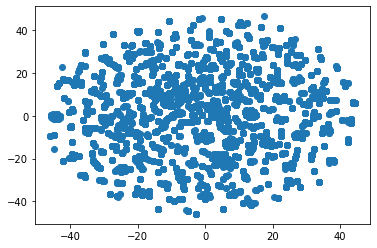

In [26]:
plt.scatter(tsne_tfidf[:,0],tsne_tfidf[:,1])

old method

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
train_matrix = tfidf_model.fit_transform(train['title'].dropna()).todense()
tfidf_model = TfidfVectorizer()
test_matrix = tfidf_model.fit_transform(test['title'].dropna()).todense()

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components= 8, max_iter = 10)
train_dt = lda.fit_transform(train_matrix)
train_features = pd.DataFrame(train_dt, columns = ['T1','T2','T3','T4','T5','T6','T7','T8'])

lda = LatentDirichletAllocation(n_components= 8, max_iter = 10)
test_dt = lda.fit_transform(test_matrix)
test_features = pd.DataFrame(test_dt, columns = ['T1','T2','T3','T4','T5','T6','T7','T8'])

columns = ['T1','T2','T3','T4','T5','T6','T7','T8']
for c in columns:
  train[c] = train['title']
  train[c].iloc[train['title'].dropna().index.tolist()] = train_features[c].values
  test[c] = test['title']
  test[c].iloc[test['title'].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

train_embedding = model.encode(train['title'].dropna().tolist())
test_embedding = model.encode(test['title'].dropna().tolist())

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
np.save('/content/drive/MyDrive/CS5228 Project/title_train.npy',train_embedding)
np.save('/content/drive/MyDrive/CS5228 Project/title_test.npy',test_embedding)

In [30]:
train_embedding = np.load('/content/drive/MyDrive/CS5228 Project/title_train.npy')
test_embedding = np.load('/content/drive/MyDrive/CS5228 Project/title_test.npy')

In [ ]:
train_embed = pd.DataFrame(train_embedding, columns = ['title_'+str(i) for i in range(768)])
test_embed = pd.DataFrame(test_embedding, columns = ['title_'+str(i) for i in range(768)])
columns = train_embed.columns.tolist()
for c in columns:
  train[c] = train['title']
  train[c].iloc[train['title'].dropna().index.tolist()] = train_embed[c].values
  test[c] = test['title']
  test[c].iloc[test['title'].dropna().index.tolist()] = test_embed[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
pca_train = pca.fit_transform(train_embedding)
pca = PCA(n_components=64)
pca_test = pca.fit_transform(test_embedding)

train_features = pd.DataFrame(pca_train, columns = ['TE_'+str(i) for i in range(64)])
test_features = pd.DataFrame(pca_test, columns = ['TE_'+str(i) for i in range(64)])

columns = train_features.columns.tolist()
for c in columns:
  train[c] = train['title']
  train[c].iloc[train['title'].dropna().index.tolist()] = train_features[c].values
  test[c] = test['title']
  test[c].iloc[test['title'].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [32]:
train = train.drop(columns = ['title'])
test = test.drop(columns = ['title'])

#### coe_validity (new features)

In [ ]:
for df in [train, test]:
  column_details(regex='coe_validity', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

coe_validity:  float64, 677, %70.55
[ 1825.  3628.  3629.  3633.  3640.  3642.  3648.  3649.  3650.  4908.
  4980.  5066.  5115.  5129.  5168.  5175.  5178.  5181.  5187.  5207.
  5223.  5233.  5235.  5241.  5243.  5247.  5248.  5257.  5259.  5262.
  5264.  5266.  5268.  5270.  5272.  5274.  5277.  5278.  5284.  5286.
  5288.  5290.  5292.  5298.  5299.  5303.  5310.  5312.  5314.  5316.
  5317.  5318.  5321.  5324.  5326.  5327.  5328.  5329.  5330.  5331.
  5337.  5339.  5340.  5344.  5345.  5348.  5354.  5355.  5357.  5358.
  5359.  5360.  5362.  5363.  5365.  5366.  5367.  5368.  5369.  5371.
  5373.  5376.  5377.  5378.  5379.  5382.  5383.  5384.  5386.  5388.
  5389.  5390.  5391.  5392.  5393.  5394.  5395.  5396.  5397.  5398.
  5399.  5400.  5401.  5402.  5403.  5404.  5405.  5406.  5407.  5408.
  5409.  5410.  5411.  5412.  5413.  5414.  5415.  5416.  5417.  5418.
  5419.  5420.  5421.  5422.  5423.  5424.  5

In [33]:
# fill nan value using mode 
train['coe_validity'] =  train['coe_validity'].fillna(train['coe_validity'].mode()[0])
test['coe_validity'] = test['coe_validity'].fillna(test['coe_validity'].mode()[0])

#### engine_type (new features)

In [ ]:
for df in [train, test]:
  column_details(regex='engine_type', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

engine_type:  float64, 44, %32.31
[ 1.    1.1   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.2
  2.3   2.4   2.5   2.7   2.8   2.9   3.    3.2   3.3   3.4   3.5   3.6
  3.7   3.8   4.    4.2   4.3   4.6   4.7   4.8   4.9   5.    5.2   5.3
  5.6   6.    6.3   6.75 14.28 18.36 26.4  39.2    nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

engine_type:  float64, 40, %31.72
[0.8  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.2  2.3
 2.4  2.5  2.7  2.8  2.9  3.   3.2  3.4  3.5  3.6  3.7  3.8  3.9  4.
 4.2  4.3  4.6  4.7  4.8  4.9  5.   5.2  5.6  6.   6.3  6.75  nan]



In [34]:
#fill nan using mode
train['engine_type'] =  train['engine_type'].fillna(train['engine_type'].mode()[0])
test['engine_type'] = test['engine_type'].fillna(test['engine_type'].mode()[0])

#### Transmission

In [ ]:
for df in [train, test]:
  column_details(regex='transmission', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

transmission:  object, 2, %0.0
['auto' 'manual']

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

transmission:  object, 2, %0.0
['auto' 'manual']



#### make

In [ ]:
for df in [train, test]:
  column_details(regex='make', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

make:  object, 77, %0.0
['alfa romeo' 'alpine' 'aston martin' 'audi' 'austin' 'bentley' 'bmw'
 'byd' 'chery' 'chevrolet' 'chrysler' 'citroen' 'cupra' 'daf' 'daihatsu'
 'daimler' 'dodge' 'dongfeng' 'ferrari' 'fiat' 'ford' 'foton'
 'golden dragon' 'hafei' 'higer' 'hino' 'honda' 'hummer' 'hyundai'
 'infiniti' 'international' 'isuzu' 'iveco' 'jaguar' 'jeep' 'joylong'
 'kia' 'lamborghini' 'land rover' 'lexus' 'lotus' 'man' 'maserati' 'maxus'
 'mazda' 'mclaren' 'mercedes' 'mercedes-benz' 'mg' 'mini' 'mitsubishi'
 'mitsuoka' 'morris' 'nissan' 'opel' 'perodua' 'peugeot' 'porsche'
 'proton' 'renault' 'riley' 'rolls-royce' 'rover' 'ruf' 'saab' 'scania'
 'seat' 'skoda' 'ssangyong' 'subaru' 'suzuki' 'tesla' 'toyota' 'ud'
 'volkswagen' 'volvo' 'yutong']

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

make:  object, 65, %0.0
['alfa romeo' 'aston martin' 'audi' 'bentley' 'bmw' 'byd' 'cadillac'
 'chevrolet' 'citroen

#### model

In [ ]:
for df in [train, test]:
  column_details(regex='model', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

model:  object, 692, %0.0
['107' '116d' '116i' '118i' '120i' '125i' '12c' '1300' '135i' '14.280'
 '159' '190e' '1m' '2' '200' '2008' '200sx' '207cc' '208' '216' '216d'
 '216i' '218d' '218i' '220' '220i' '225xe' '228i' '230' '230i' '250'
 '280s' '3' '3008' '300c' '300ce' '300gd' '300sel' '300sl' '308' '315'
 '316i' '318ci' '318i' '320ce' '320d' '320i' '323i' '325ci' '325i' '328i'
 '330ci' '330e' '330i' '335i' '340i' '348' '360' '3800s' '420i' '428i'
 '430i' '435i' '440i' '450slc' '458' '488' '500' '5008' '508' '520d'
 '520i' '523i' '525i' '528i' '530e' '530i' '535i' '540i' '570s' '575m'
 '599' '600lt' '630ci' '630i' '640i' '650i' '650s' '718' '720s' '730d'
 '730i' '730li' '740e' '740i' '740li' '750li' '840i' '850i' '86' '9-3'
 '9-5' '900s' '911' '924' '944' 'a1' 'a110' 'a156' 'a180' 'a200' 'a250'
 'a3' 'a35' 'a4' 'a45' 'a5' 'a6' 'a7' 'a8' 'accent' 'accord'
 'activehybrid' 'actros' 'actyon' 'airwave' 'alhambra' 'allion' '

In [36]:
train['make_model_combined'] = train['make'] + ' '+ train['model']
test['make_model_combined'] = test['make'] + ' '+ test['model']

In [37]:
for col in ['make','model']:
  new_versions_col = set(test[col].unique()) - set(train[col].unique()) 
  test[col] =test[col].apply(lambda x: np.nan if x in new_versions_col else x)

#### description

Try to use some nlp method: word embedding to sentence embeddding

In [ ]:
for df in [train, test]:
  column_details(regex='description', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

description:  object, 14006, %2.06
['"das weltauto" pre-owned vehicles by skoda, singapore\'s only certified volkswagen pre-owned centre, certified vehicle history and mileage, 115 points check with certificate of quality, 5 years warranty till mar 2026.'
 '"das weltauto" pre-owned vehicles by volkswagen, singapore\'s only certified volkswagen pre-owned centre, certified vehicle history and mileage'
 '"das weltauto" pre-owned vehicles by volkswagen, singapore\'s only certified volkswagen pre-owned centre, certified vehicle history and mileage, 115 points check with certificate of quality, warranty till jul 2024.'
 ...
 'zippy multi-award urban car award winner! all electric powertrain with 152hp 315nm. 50-50 weight distribution. regenerative braking. quick ac/dc charging. up to 200km range. fascinating high-tech interior. smartphone integration. handsfree proximity entry & go! auto parking pilot. glass roof. pop-out doo

In [38]:
# low mileage # 1 or 0
# 1 year warranty # number of warranty
train_warranty = train['description'].str.extract(r'(\d+ years* warranty)')
test_warranty = test['description'].str.extract(r'(\d+ years* warranty)')

train_warranty_extend = train['description'].str.extract(r'(\d+ years* extended)')
test_warranty_extend = test['description'].str.extract(r'(\d+ years* extended)')

train_low_mileage = train['description'].str.extract(r'(low mileage)')
test_low_mileage = test['description'].str.extract(r'(low mileage)')

In [39]:
train['low_mileage'] = pd.Series([0 for _ in range(len(train))])
test['low_mileage'] = pd.Series([0 for _ in range(len(test))])

In [40]:
train['low_mileage'].iloc[train_low_mileage.dropna().index.tolist()] = pd.Series([1 for _ in range(len(train_low_mileage.dropna()))])
test['low_mileage'].iloc[test_low_mileage.dropna().index.tolist()] = pd.Series([1 for _ in range(len(test_low_mileage.dropna()))])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [41]:
def get_days(warranty):
  if warranty is np.nan:
    return warranty
  num = re.findall('\d+',warranty)
  return int(num[0])*365

In [42]:
train_warranty[0].iloc[train_warranty_extend.dropna().index.tolist()] = train_warranty_extend[0].iloc[train_warranty_extend.dropna().index.tolist()]
test_warranty[0].iloc[test_warranty_extend.dropna().index.tolist()] = test_warranty_extend[0].iloc[test_warranty_extend.dropna().index.tolist()]

In [43]:
train_warranty[0] = train_warranty[0].map(get_days)
test_warranty[0] = test_warranty[0].map(get_days)

In [44]:
train['warranty'] = train_warranty[0]
test['warranty'] = test_warranty[0]

In [ ]:
# embedding to try
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
train_embedding = model.encode(train['description'].dropna().tolist())
test_embedding = model.encode(test['description'].dropna().tolist())

In [ ]:
np.save('/content/drive/MyDrive/CS5228 Project/description_train.npy',train_embedding)
np.save('/content/drive/MyDrive/CS5228 Project/description_test.npy',test_embedding)

In [45]:
train_embedding = np.load('/content/drive/MyDrive/CS5228 Project/description_train.npy')
test_embedding = np.load('/content/drive/MyDrive/CS5228 Project/description_test.npy')

In [ ]:
train_embed = pd.DataFrame(train_embedding, columns = ['des_'+str(i) for i in range(768)])
test_embed = pd.DataFrame(test_embedding, columns = ['des_'+str(i) for i in range(768)])
columns = train_embed.columns.tolist()
for c in columns:
  train[c] = train['description']
  train[c].iloc[train['description'].dropna().index.tolist()] = train_embed[c].values
  test[c] = test['description']
  test[c].iloc[test['description'].dropna().index.tolist()] = test_embed[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
pca_train = pca.fit_transform(train_embedding)

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
pca_test = pca.fit_transform(test_embedding)

In [48]:
train_features = pd.DataFrame(pca_train, columns = ['DE_'+str(i) for i in range(64)])
test_features = pd.DataFrame(pca_test, columns = ['DE_'+str(i) for i in range(64)])

In [49]:
columns = train_features.columns.tolist()
for c in columns:
  train[c] = train['description']
  train[c].iloc[train['description'].dropna().index.tolist()] = train_features[c].values
  test[c] = test['description']
  test[c].iloc[test['description'].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
train_matrix = tfidf_model.fit_transform(train['description'].dropna()).todense()
tfidf_model = TfidfVectorizer()
test_matrix = tfidf_model.fit_transform(test['description'].dropna()).todense()

In [51]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components= 8, max_iter = 10)
train_dt = lda.fit_transform(train_matrix)
train_features = pd.DataFrame(train_dt, columns = ['D1','D2','D3','D4','D5','D6','D7','D8'])

In [52]:
lda = LatentDirichletAllocation(n_components= 8, max_iter = 10)
test_dt = lda.fit_transform(test_matrix)
test_features = pd.DataFrame(test_dt, columns = ['D1','D2','D3','D4','D5','D6','D7','D8'])

In [53]:
columns = ['D1','D2','D3','D4','D5','D6','D7','D8']
for c in columns:
  train[c] = train['description']
  train[c].iloc[train['description'].dropna().index.tolist()] = train_features[c].values
  test[c] = test['description']
  test[c].iloc[test['description'].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10, max_features=180000, tokenizer=tokenize,ngram_range=(1, 2))
vz_train = vectorizer.fit_transform(train['description'].dropna()).todense()
vz_test = vectorizer.fit_transform(test['description'].dropna()).todense()

from sklearn.decomposition import TruncatedSVD
n_comp=30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_train = svd.fit_transform(vz_train)
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_test = svd.fit_transform(vz_test)

train_features = pd.DataFrame(svd_train, columns = ['svd' + str(i) + '_descrip' for i in range(30)])
test_features = pd.DataFrame(svd_test, columns = ['svd' + str(i) + '_descrip' for i in range(30)])
columns = train_features.columns.tolist()
for c in columns:
  train[c] = train['description']
  train[c].iloc[train['description'].dropna().index.tolist()] = train_features[c].values
  test[c] = test['description']
  test[c].iloc[test['description'].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [55]:
train = train.drop(columns = ['description'])
test = test.drop(columns = ['description'])

#### warranty (new features)

In [ ]:
for df in [train, test]:
  column_details(regex='warranty', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

warranty:  float64, 7, %93.71
[ 365.  730. 1095. 1460. 1825. 2555. 3650.   nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

warranty:  float64, 6, %93.94
[ 365.  730. 1095. 1825. 3285. 3650.   nan]



In [56]:
train['warranty'] = train['warranty'].fillna(0)
test['warranty'] = test['warranty'].fillna(0)

#### manufactured

In [ ]:
for df in [train, test]:
  column_details(regex='manufactured', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

manufactured:  float64, 60, %1.16
[1933. 1948. 1959. 1962. 1964. 1966. 1967. 1968. 1969. 1970. 1971. 1972.
 1973. 1974. 1975. 1976. 1977. 1978. 1979. 1980. 1981. 1982. 1983. 1984.
 1985. 1986. 1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997.
 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009.
 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018. 2019. 2020. 2021.
   nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

manufactured:  float64, 50, %1.22
[1952. 1957. 1958. 1962. 1963. 1964. 1966. 1967. 1969. 1970. 1971. 1972.
 1973. 1974. 1976. 1978. 1981. 1982. 1983. 1984. 1987. 1989. 1990. 1991.
 1992. 1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007.
 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018. 2019.
 2020. 2021.   nan]



In [57]:
# wrong data in train 2291
for df in [train, test]:
  df['manufactured'] = df['manufactured'].clip(0,2021)

#### reg_date

In [ ]:
for df in [train, test]:
  column_details(regex='reg_date', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

reg_date:  object, 3889, %1.2
['01-apr-1998' '01-apr-2008' '01-apr-2010' ... '31-oct-2018' '31-oct-2019'
 nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

reg_date:  object, 2505, %1.22
['01-apr-2008' '01-apr-2009' '01-apr-2010' ... '31-oct-2018' '31-oct-2019'
 nan]



In [58]:
from datetime import timedelta
life_span_train = pd.to_datetime(train['reg_date']) + timedelta(days = 20*365)
life_span_test = pd.to_datetime(test['reg_date']) + timedelta(days = 20*365)

In [59]:
# fill nan value in lifespan
idx = train['lifespan'].isnull()
idx = [i for i in range(len(idx)) if idx[i] == True]
train['lifespan'].iloc[idx] = life_span_train.iloc[idx]

idx = test['lifespan'].isnull()
idx = [i for i in range(len(idx)) if idx[i] == True]
test['lifespan'].iloc[idx] = life_span_test.iloc[idx]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [60]:
train['reg_year'] = pd.to_datetime(train['reg_date']).dt.year
train['reg_month'] = pd.to_datetime(train['reg_date']).dt.month

In [61]:
test['reg_year'] = pd.to_datetime(test['reg_date']).dt.year
test['reg_month'] = pd.to_datetime(test['reg_date']).dt.month

#### type_of_vehicle

In [ ]:
for df in [train, test]:
  column_details(regex='type_of_vehicle', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

type_of_vehicle:  object, 11, %0.0
['bus/mini bus' 'hatchback' 'luxury sedan' 'mid-sized sedan' 'mpv'
 'others' 'sports car' 'stationwagon' 'suv' 'truck' 'van']

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

type_of_vehicle:  object, 11, %0.0
['bus/mini bus' 'hatchback' 'luxury sedan' 'mid-sized sedan' 'mpv'
 'others' 'sports car' 'stationwagon' 'suv' 'truck' 'van']



#### category

split each description in some feature

In [ ]:
# split 1 0
for df in [train, test]:
  column_details(regex='category', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

category:  object, 193, %0.0
['-' 'almost new car' 'almost new car, electric cars'
 'almost new car, low mileage car' 'almost new car, premium ad car'
 'almost new car, premium ad car, electric cars'
 'almost new car, premium ad car, low mileage car' 'coe car'
 'coe car, consignment car' 'coe car, consignment car, hybrid cars'
 'coe car, consignment car, low mileage car' 'coe car, direct owner sale'
 'coe car, direct owner sale, hybrid cars'
 'coe car, direct owner sale, low mileage car'
 'coe car, direct owner sale, low mileage car, hybrid cars'
 'coe car, direct owner sale, low mileage car, vintage cars'
 'coe car, direct owner sale, rare & exotic'
 'coe car, direct owner sale, rare & exotic, low mileage car'
 'coe car, direct owner sale, rare & exotic, low mileage car, vintage cars'
 'coe car, direct owner sale, rare & exotic, vintage cars'
 'coe car, direct owner sale, sta evaluated car, low mileage car'
 'coe car, 

In [ ]:
train_category = train['category'].unique()
test_category = test['category'].unique()

In [ ]:
all_categories = set()
for each in train_category:
  all_categories.update(each.split(','))
for each in test_category:
  all_categories.update(each.split(','))

In [ ]:
all_categories.remove('-')

In [ ]:
all_categories = [c.strip() for c in all_categories]
all_categories = set(all_categories)

In [ ]:
def extract_feature(feature, x):
  x = x.strip()
  features = x.split(',')
  if feature in features:
    return 1
  else:
    return 0

for e in all_categories:
  train[e] = train['category'].apply(extract_feature, args = (e,))
  test[e] = test['category'].apply(extract_feature, args = (e,)) 

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
train_matrix = tfidf_model.fit_transform(train['category'].dropna()).todense()
tfidf_model = TfidfVectorizer()
test_matrix = tfidf_model.fit_transform(test['category'].dropna()).todense()

In [63]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components= 8, max_iter = 10)
train_dt = lda.fit_transform(train_matrix)
train_features = pd.DataFrame(train_dt, columns = ['C1','C2','C3','C4','C5','C6','C7','C8'])

In [64]:
lda = LatentDirichletAllocation(n_components= 8, max_iter = 10)
test_dt = lda.fit_transform(test_matrix)
test_features = pd.DataFrame(test_dt, columns = ['C1','C2','C3','C4','C5','C6','C7','C8'])

In [65]:
columns = ['C1','C2','C3','C4','C5','C6','C7','C8']
for c in columns:
  train[c] = train['category']
  train[c].iloc[train['category'].dropna().index.tolist()] = train_features[c].values
  test[c] = test['category']
  test[c].iloc[test['category'].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
## embedding to be explored
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')
train_embedding = model.encode(train['category'].dropna().tolist())
test_embedding = model.encode(test['category'].dropna().tolist())

In [ ]:
np.save('/content/drive/MyDrive/CS5228 Project/category_train.npy',train_embedding)
np.save('/content/drive/MyDrive/CS5228 Project/category_test.npy',test_embedding)

In [66]:
train_embedding = np.load('/content/drive/MyDrive/CS5228 Project/category_train.npy')
test_embedding = np.load('/content/drive/MyDrive/CS5228 Project/category_test.npy')

In [ ]:
train_embed = pd.DataFrame(train_embedding, columns = ['category_'+str(i) for i in range(768)])
test_embed = pd.DataFrame(test_embedding, columns = ['category_'+str(i) for i in range(768)])
columns = train_embed.columns.tolist()
for c in columns:
  train[c] = train['category']
  train[c].iloc[train['category'].dropna().index.tolist()] = train_embed[c].values
  test[c] = test['category']
  test[c].iloc[test['category'].dropna().index.tolist()] = test_embed[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [67]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
pca_train = pca.fit_transform(train_embedding)
pca = PCA(n_components=64)
pca_test = pca.fit_transform(test_embedding)

In [68]:
train_features = pd.DataFrame(pca_train, columns = ['CE_'+str(i) for i in range(64)])
test_features = pd.DataFrame(pca_test, columns = ['CE_'+str(i) for i in range(64)])

In [69]:
columns = train_features.columns.tolist()
for c in columns:
  train[c] = train['category']
  train[c].iloc[train['category'].dropna().index.tolist()] = train_features[c].values
  test[c] = test['category']
  test[c].iloc[test['category'].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

column_name = 'category'
vectorizer = TfidfVectorizer(min_df=10, max_features=180000, tokenizer=tokenize,ngram_range=(1, 2))
vz_train = vectorizer.fit_transform(train[column_name].dropna()).todense()
vz_test = vectorizer.fit_transform(test[column_name].dropna()).todense()

from sklearn.decomposition import TruncatedSVD

n_comp=30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_train = svd.fit_transform(vz_train)
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_test = svd.fit_transform(vz_test)

train_features = pd.DataFrame(svd_train, columns = ['svd' + str(i) + '_' + column_name for i in range(30)])
test_features = pd.DataFrame(svd_test, columns = ['svd' + str(i) + '_' + column_name for i in range(30)])
columns = train_features.columns.tolist()
for c in columns:
  train[c] = train[column_name]
  train[c].iloc[train[column_name].dropna().index.tolist()] = train_features[c].values
  test[c] = test[column_name]
  test[c].iloc[test[column_name].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [72]:
train = train.drop(columns = ['category'])
test = test.drop(columns = ['category'])

#### curb_weight

can clip some value or keep original

In [ ]:
for df in [train, test]:
  column_details(regex='curb_weight', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

curb_weight:  float64, 795, %3.45
[2.000e+00 7.860e+02 7.950e+02 8.000e+02 8.050e+02 8.060e+02 8.200e+02
 8.300e+02 8.400e+02 8.500e+02 8.520e+02 8.600e+02 8.650e+02 8.700e+02
 8.720e+02 8.800e+02 8.900e+02 8.910e+02 9.000e+02 9.100e+02 9.150e+02
 9.300e+02 9.400e+02 9.450e+02 9.500e+02 9.550e+02 9.700e+02 9.800e+02
 9.900e+02 9.950e+02 1.000e+03 1.010e+03 1.020e+03 1.030e+03 1.035e+03
 1.036e+03 1.038e+03 1.040e+03 1.041e+03 1.044e+03 1.045e+03 1.046e+03
 1.048e+03 1.050e+03 1.052e+03 1.055e+03 1.058e+03 1.060e+03 1.065e+03
 1.067e+03 1.068e+03 1.070e+03 1.075e+03 1.078e+03 1.079e+03 1.080e+03
 1.081e+03 1.085e+03 1.086e+03 1.088e+03 1.090e+03 1.095e+03 1.096e+03
 1.097e+03 1.100e+03 1.102e+03 1.105e+03 1.110e+03 1.111e+03 1.115e+03
 1.119e+03 1.120e+03 1.122e+03 1.125e+03 1.126e+03 1.129e+03 1.130e+03
 1.131e+03 1.132e+03 1.135e+03 1.138e+03 1.139e+03 1.140e+03 1.145e+03
 1.150e+03 1.151e+03 1.155e+03 1.158e+03 1.160e

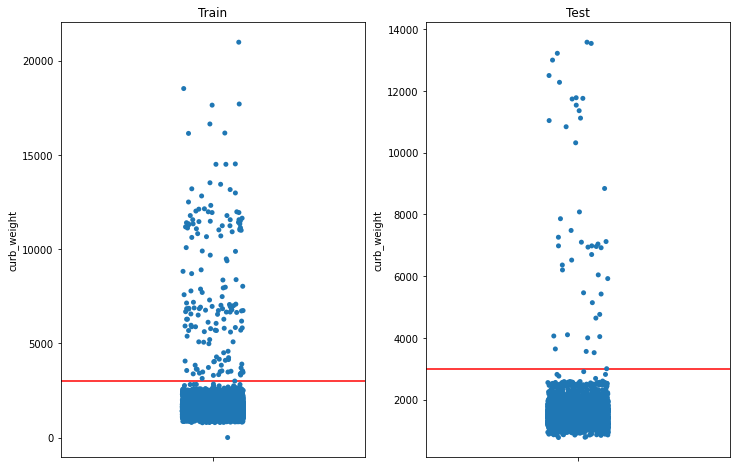

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='curb_weight', data=train)
plt.axhline(3000, color='red')
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='curb_weight', data=test)
plt.axhline(3000, color='red')
plt.title('Test');

In [ ]:
# for df in [train, test]:
#   df['curb_weight'] = df['curb_weight'].clip(0,3000)

#### power

In [ ]:
for df in [train, test]:
  column_details(regex='power', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

power:  float64, 301, %13.92
[ 40.5  42.5  43.   45.   47.   47.1  48.5  49.   50.   51.   54.   55.
  55.9  57.   58.   59.   60.   60.5  63.   64.   64.9  65.   66.   67.
  68.   69.   69.3  69.9  70.   72.   73.   73.6  74.   75.   76.   77.
  79.   80.   81.   82.   84.   84.6  85.   86.   87.   87.5  88.   88.3
  89.   89.7  90.   90.2  91.   91.1  91.2  92.   92.7  93.   93.8  94.1
  95.   95.3  95.6  96.   96.5  96.7  97.   98.5  99.  100.  100.5 101.
 103.  103.6 104.  105.  105.1 106.  106.3 107.  108.  108.9 109.  109.8
 110.  111.  112.  113.  114.  114.7 115.  117.  118.  119.  119.4 120.
 121.  121.4 122.  123.  125.  126.  127.  128.  129.  130.  130.9 131.
 132.  133.  134.  135.  136.  137.  137.2 138.  139.3 140.  141.  142.
 143.  145.  146.  147.  148.  149.  150.  151.  152.  153.  154.  155.
 156.  156.5 157.  158.  160.  162.  164.  165.  166.  169.  170.  171.
 173.  174.  175.  176.  177.  178.  

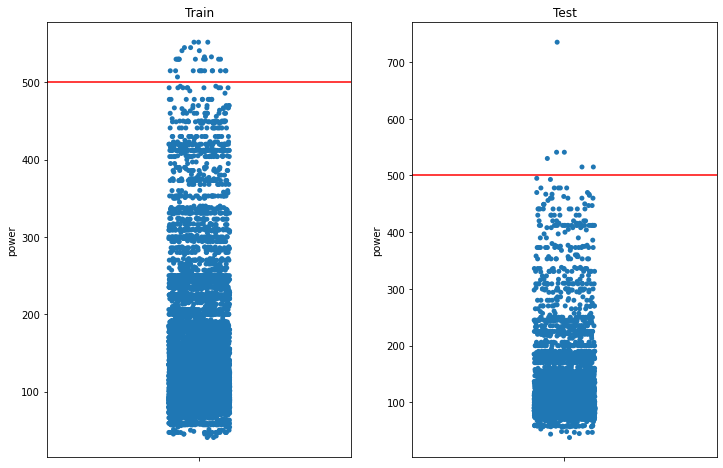

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='power', data=train)
plt.axhline(500, color='red')
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='power', data=test)
plt.axhline(500, color='red')
plt.title('Test');

#### fuel_type

For the nan value, maybe we can extract from other features such as `category`, `description`

In [ ]:
for df in [train, test]:
  column_details(regex='fuel_type', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

fuel_type:  object, 4, %79.21
['diesel' 'electric' 'petrol' 'petrol-electric' nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

fuel_type:  object, 4, %78.98
['diesel' 'electric' 'petrol' 'petrol-electric' nan]



In [73]:
train['fuel_type'] = train['fuel_type'].fillna(train['fuel_type'].mode()[0])
test['fuel_type'] = test['fuel_type'].fillna(test['fuel_type'].mode()[0])

#### engine_cap

In [ ]:
for df in [train, test]:
  column_details(regex='engine_cap', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

engine_cap:  float64, 332, %0.32
[    0.   647.   658.   659.   797.   970.   988.   989.   996.   998.
   999.  1051.  1086.  1098.  1166.  1192.  1193.  1196.  1197.  1198.
  1199.  1242.  1248.  1275.  1285.  1296.  1298.  1308.  1310.  1317.
  1318.  1328.  1332.  1333.  1335.  1339.  1353.  1362.  1364.  1368.
  1371.  1372.  1373.  1386.  1390.  1395.  1397.  1398.  1399.  1460.
  1461.  1462.  1468.  1490.  1493.  1495.  1496.  1497.  1498.  1499.
  1560.  1561.  1573.  1580.  1584.  1586.  1587.  1590.  1591.  1595.
  1596.  1597.  1598.  1600.  1618.  1668.  1685.  1686.  1699.  1779.
  1781.  1794.  1795.  1796.  1797.  1798.  1799.  1809.  1834.  1850.
  1870.  1895.  1898.  1910.  1950.  1958.  1962.  1968.  1969.  1970.
  1975.  1984.  1985.  1986.  1987.  1988.  1990.  1991.  1993.  1994.
  1995.  1996.  1997.  1998.  1999.  2019.  2035.  2143.  2148.  2151.
  2156.  2157.  2174.  2179.  2184.  2195.  2198

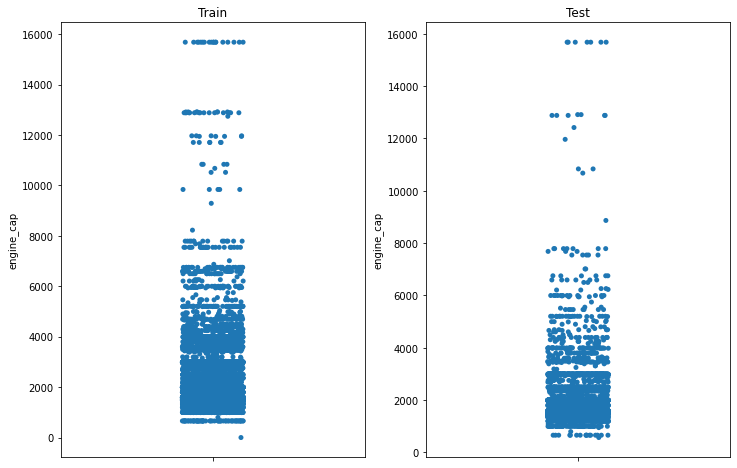

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='engine_cap', data=train)
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='engine_cap', data=test)
plt.title('Test');

#### no_of_owners

In [ ]:
for df in [train, test]:
  column_details(regex='no_of_owners', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

no_of_owners:  float64, 6, %1.05
[ 1.  2.  3.  4.  5.  6. nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

no_of_owners:  float64, 6, %1.12
[ 1.  2.  3.  4.  5.  6. nan]



#### depreciation

In [ ]:
for df in [train, test]:
  column_details(regex='depreciation', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

depreciation:  float64, 2893, %2.58
[  2680.   3280.   3410. ... 690800. 865610.     nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

depreciation:  float64, 1763, %2.64
[  3250.   3950.   3960. ... 353900. 804210.     nan]



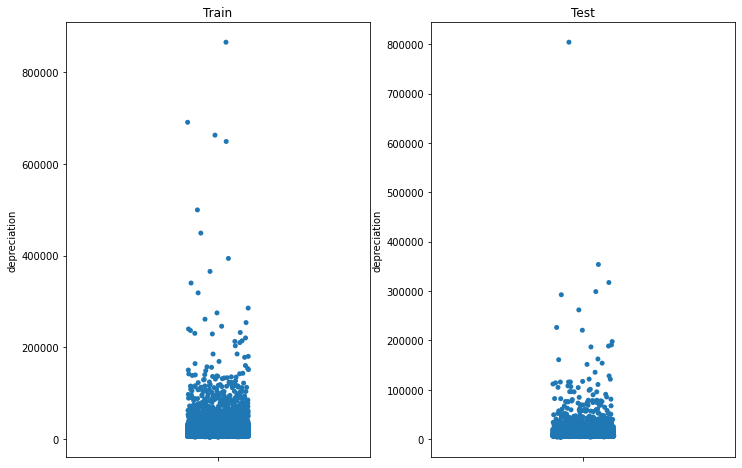

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='depreciation', data=train)
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='depreciation', data=test)
plt.title('Test');

#### coe

In [ ]:
for df in [train, test]:
  column_details(regex='coe', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

coe:  float64, 2102, %5.31
[1.0000e+01 3.2190e+03 3.2880e+03 ... 9.7000e+04 9.7889e+04        nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

coe:  float64, 1214, %4.9
[1.0000e+01 3.1340e+03 3.2280e+03 ... 9.7000e+04 9.7889e+04        nan]



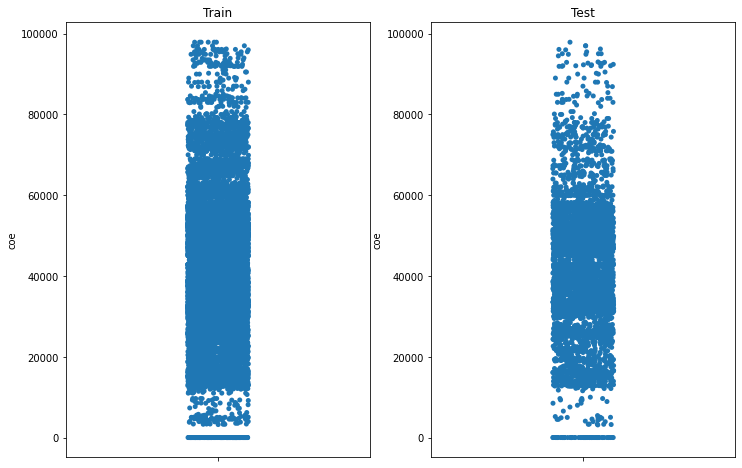

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='coe', data=train)
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='coe', data=test)
plt.title('Test');

#### road_tax

In [ ]:
for df in [train, test]:
  column_details(regex='road_tax', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

road_tax:  float64, 542, %12.83
[   50.    70.    78.    90.   100.   108.   120.   124.   126.   182.
   184.   228.   236.   238.   242.   244.   259.   270.   280.   314.
   326.   390.   392.   424.   431.   456.   465.   468.   474.   486.
   489.   506.   507.   508.   510.   530.   534.   536.   546.   548.
   559.   572.   575.   578.   586.   588.   590.   600.   604.   606.
   608.   610.   614.   619.   620.   624.   626.   644.   649.   662.
   671.   679.   680.   682.   684.   689.   694.   701.   702.   708.
   710.   712.   714.   722.   730.   731.   732.   736.   738.   740.
   742.   743.   744.   748.   750.   751.   752.   759.   766.   767.
   792.   799.   801.   806.   807.   810.   812.   813.   814.   816.
   818.   821.   826.   849.   858.   860.   866.   874.   876.   879.
   881.   883.   884.   885.   886.   887.   888.   889.   890.   912.
   927.   932.   939.   943.   946.   952.   954.

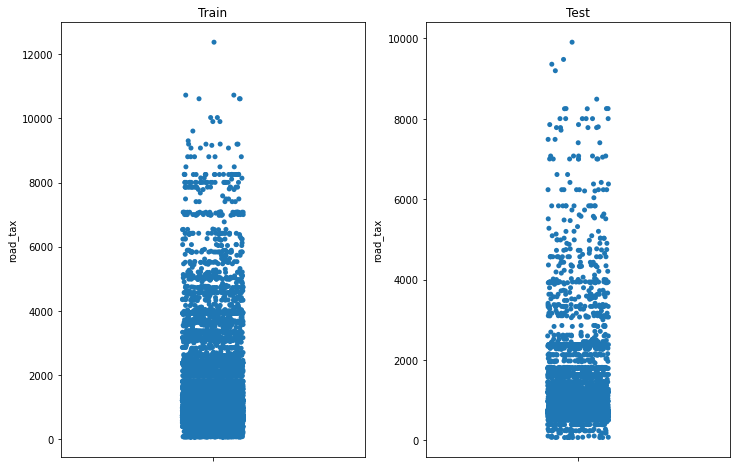

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='road_tax', data=train)
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='road_tax', data=test)
plt.title('Test');

#### dereg_value

In [ ]:
for df in [train, test]:
  column_details(regex='dereg_value', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

dereg_value:  float64, 12332, %7.08
[9.70000e+01 3.68000e+02 4.83000e+02 ... 6.36342e+05 6.53862e+05
         nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

dereg_value:  float64, 4154, %6.7
[3.59000e+02 7.15000e+02 1.54900e+03 ... 6.70017e+05 7.86967e+05
         nan]



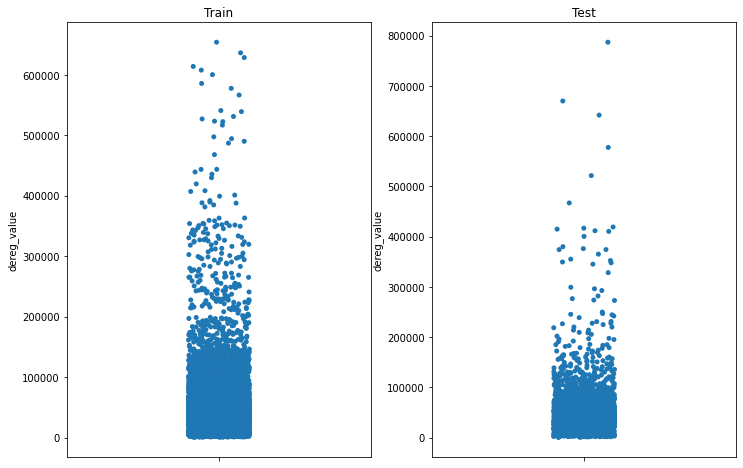

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='dereg_value', data=train)
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='dereg_value', data=test)
plt.title('Test');

#### mileage

In [ ]:
for df in [train, test]:
  column_details(regex='mileage', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

mileage:  float64, 4641, %22.19
[1.00000e+00 3.00000e+00 5.00000e+00 ... 4.82000e+05 7.40459e+05
         nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

mileage:  float64, 1685, %22.88
[6.00000e+00 7.00000e+00 8.00000e+00 ... 4.08000e+05 5.98345e+05
         nan]



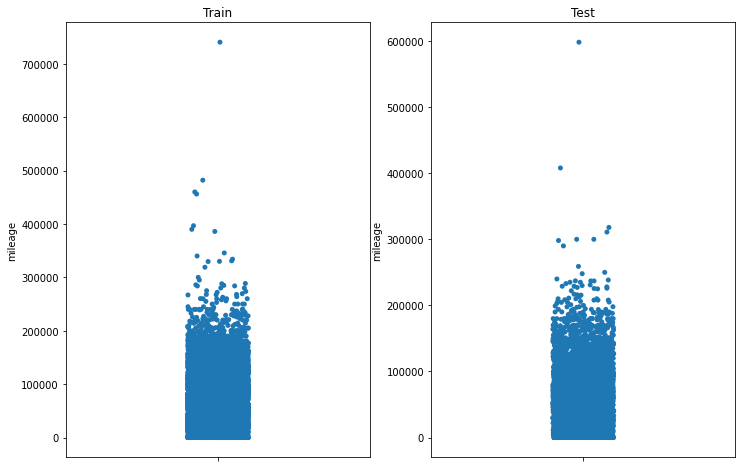

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='mileage', data=train)
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='mileage', data=test)
plt.title('Test');

#### omv

In [ ]:
for df in [train, test]:
  column_details(regex='omv', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

omv:  float64, 10653, %0.24
[8.88000e+02 1.93100e+03 2.08900e+03 ... 5.92131e+05 1.15000e+06
         nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

omv:  float64, 4027, %0.24
[  3032.   3848.   4000. ... 617416. 741523.     nan]



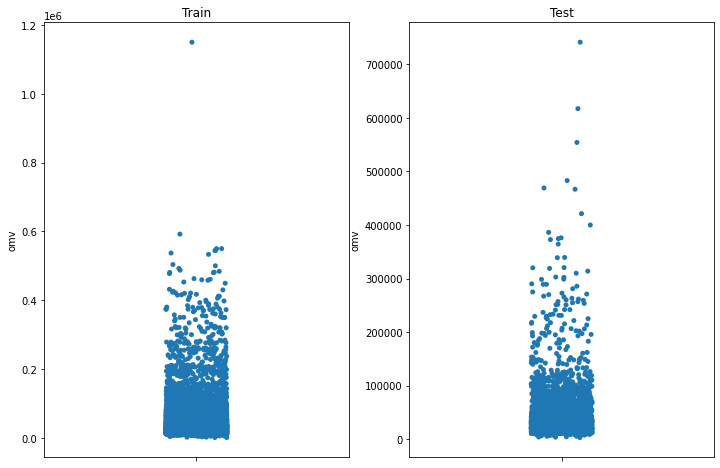

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='omv', data=train)
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='omv', data=test)
plt.title('Test');

#### arf

In [ ]:
for df in [train, test]:
  column_details(regex='arf', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

arf:  float64, 10446, %1.69
[6.30000e+01 6.40000e+01 9.00000e+01 ... 8.38661e+05 8.58230e+05
         nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

arf:  float64, 3876, %1.74
[4.40000e+01 1.11000e+02 1.71000e+02 ... 9.69571e+05 1.08335e+06
         nan]



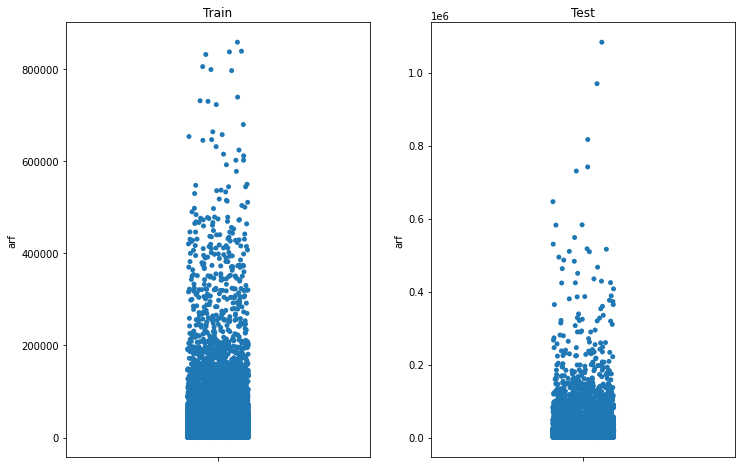

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
sns.stripplot(y='arf', data=train)
plt.title('Train')

plt.subplot(122)
sns.stripplot(y='arf', data=test)
plt.title('Test');

#### lifespan

lifespan is the end date, we can create features like how many days can this vehicle be used (lifespan - manufactured)

In [ ]:
for df in [train, test]:
  column_details(regex='lifespan', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

lifespan:  object, 1115, %89.86
['01-aug-2030' '01-aug-2037' '01-aug-2041' ... '31-may-2041' '31-oct-2033'
 nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

lifespan:  object, 422, %89.92
['01-apr-2023' '01-aug-2036' '01-feb-2027' '01-jun-2041' '01-may-2039'
 '01-oct-2027' '01-oct-2037' '01-oct-2038' '01-sep-2035' '02-apr-2032'
 '02-apr-2037' '02-feb-2036' '02-jan-2028' '02-jan-2038' '02-jan-2040'
 '02-jun-2036' '02-may-2036' '02-nov-2031' '02-nov-2035' '02-oct-2031'
 '02-sep-2035' '02-sep-2041' '03-aug-2037' '03-aug-2040' '03-aug-2041'
 '03-dec-2035' '03-dec-2038' '03-may-2036' '03-may-2037' '03-nov-2034'
 '03-nov-2035' '03-sep-2035' '04-apr-2036' '04-apr-2039' '04-aug-2034'
 '04-aug-2035' '04-aug-2041' '04-feb-2035' '04-jun-2027' '04-jun-2034'
 '04-jun-2035' '04-mar-2038' '04-mar-2039' '04-nov-2034' '04-oct-2031'
 '04-oct-2032' '04-oct-2035' '05-apr-2040' '05-feb-2037' '05-jan-2036'
 '05-jul-20

In [74]:
train['lifespan_year'] = pd.to_datetime(train['lifespan']).dt.year
train['lifespan_month'] = pd.to_datetime(train['lifespan']).dt.month

In [75]:
test['lifespan_year'] = pd.to_datetime(test['lifespan']).dt.year
test['lifespan_month'] = pd.to_datetime(test['lifespan']).dt.month

#### features

use some nlp methond: sentence embedding

In [ ]:
for df in [train, test]:
  column_details(regex='features', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

features:  object, 10687, %2.73
['"best buy car of europe 2021". 3-cylinders tsi engine, 114bhp/200nm, 7-speed dsg, leather seats, climatic & rear aircon, r/camera, led drl, fog lamp. view specs of the seat leon'
 '"the perfect sedan". responsive 1.5l 4-cylinders 16v dohc vvt-i engine, 7-speed cvt, 106bhp/140nm, 17km/l, multi-function steering ctrl, 7x airbags. view specs of the toyota vios'
 '-' ...
 'young lady student 2nd car. 100% accident-free. consignment unit. please call for appointment. view specs of the volkswagen new beetle'
 'zero down. call sale person for for details. view specs of the honda shuttle'
 nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

features:  object, 3866, %2.54
["''honesty is the best policy''. view specs of the toyota dyna 150 diesel"
 '- view specs of the toyota dyna 150 diesel'
 '. view specs of the nissan cabstar' ...
 'zippy 1.4l tsi turbocharged engine power

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
train_matrix = tfidf_model.fit_transform(train['features'].dropna()).todense()
tfidf_model = TfidfVectorizer()
test_matrix = tfidf_model.fit_transform(test['features'].dropna()).todense()

In [77]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components= 8, max_iter = 10)
train_dt = lda.fit_transform(train_matrix)
train_features = pd.DataFrame(train_dt, columns = ['F1','F2','F3','F4','F5','F6','F7','F8'])

In [78]:
lda = LatentDirichletAllocation(n_components= 8, max_iter = 10)
test_dt = lda.fit_transform(test_matrix)
test_features = pd.DataFrame(test_dt, columns = ['F1','F2','F3','F4','F5','F6','F7','F8'])

In [79]:
columns = ['F1','F2','F3','F4','F5','F6','F7','F8']
for c in columns:
  train[c] = train['features']
  train[c].iloc[train['features'].dropna().index.tolist()] = train_features[c].values
  test[c] = test['features']
  test[c].iloc[test['features'].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')
train_embedding = model.encode(train['features'].dropna().tolist())
test_embedding = model.encode(test['features'].dropna().tolist())

In [ ]:
np.save('/content/drive/MyDrive/CS5228 Project/features_train.npy',train_embedding)
np.save('/content/drive/MyDrive/CS5228 Project/features_test.npy',test_embedding)

In [80]:
train_embedding = np.load('/content/drive/MyDrive/CS5228 Project/features_train.npy')
test_embedding = np.load('/content/drive/MyDrive/CS5228 Project/features_test.npy')

In [ ]:
train_embed = pd.DataFrame(train_embedding, columns = ['features_'+str(i) for i in range(768)])
test_embed = pd.DataFrame(test_embedding, columns = ['features_'+str(i) for i in range(768)])
columns = train_embed.columns.tolist()
for c in columns:
  train[c] = train['features']
  train[c].iloc[train['features'].dropna().index.tolist()] = train_embed[c].values
  test[c] = test['features']
  test[c].iloc[test['features'].dropna().index.tolist()] = test_embed[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [81]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
pca_train = pca.fit_transform(train_embedding)
pca = PCA(n_components=64)
pca_test = pca.fit_transform(test_embedding)

train_features = pd.DataFrame(pca_train, columns = ['FE_'+str(i) for i in range(64)])
test_features = pd.DataFrame(pca_test, columns = ['FE_'+str(i) for i in range(64)])

columns = train_features.columns.tolist()
for c in columns:
  train[c] = train['features']
  train[c].iloc[train['features'].dropna().index.tolist()] = train_features[c].values
  test[c] = test['features']
  test[c].iloc[test['features'].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

column_name = 'features'
vectorizer = TfidfVectorizer(min_df=10, max_features=180000, tokenizer=tokenize,ngram_range=(1, 2))
vz_train = vectorizer.fit_transform(train[column_name].dropna()).todense()
vz_test = vectorizer.fit_transform(test[column_name].dropna()).todense()

from sklearn.decomposition import TruncatedSVD

n_comp=30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_train = svd.fit_transform(vz_train)
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_test = svd.fit_transform(vz_test)

train_features = pd.DataFrame(svd_train, columns = ['svd' + str(i) + '_' + column_name for i in range(30)])
test_features = pd.DataFrame(svd_test, columns = ['svd' + str(i) + '_' + column_name for i in range(30)])
columns = train_features.columns.tolist()
for c in columns:
  train[c] = train[column_name]
  train[c].iloc[train[column_name].dropna().index.tolist()] = train_features[c].values
  test[c] = test[column_name]
  test[c].iloc[test[column_name].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### accessories

In [ ]:
for df in [train, test]:
  column_details(regex='accessories', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

accessories:  object, 11565, %16.76
['"16"sports rim, multimedia system, bluetooth, multi steering control, climatic/rear aircon, auto head lights, memory seat, reverse camera,'
 '"original bucket style" seats, touch screen audio player, reverse sensor, cold air intake, after market sport rims, knock down rear seat.'
 '-' ...
 'yellow interior leather seats, reverse sensors, touch screen dvd player.'
 'â\xa0fitted audio system, bluetooth interface, leather electric memory seats, sports rims, key-less start/stop'
 nan]

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

accessories:  object, 3818, %16.82
['*free* touch-screen dvd player + front & back camera + reverse sensor + rear floorboard. customised accessories to your likings.'
 '-'
 '0z 17" rim, hks blow off valve. reverse sensors/camera, led headlights, rear aircon, auto headlights, auto wipers, bluetooth connection.'
 ... 'wrx sti seats, sports r

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer()
train_matrix = tfidf_model.fit_transform(train['accessories'].dropna()).todense()
tfidf_model = TfidfVectorizer()
test_matrix = tfidf_model.fit_transform(test['accessories'].dropna()).todense()

In [84]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components= 8, max_iter = 10)
train_dt = lda.fit_transform(train_matrix)
train_features = pd.DataFrame(train_dt, columns = ['A1','A2','A3','A4','A5','A6','A7','A8'])

In [85]:
lda = LatentDirichletAllocation(n_components= 8, max_iter = 10)
test_dt = lda.fit_transform(test_matrix)
test_features = pd.DataFrame(test_dt, columns = ['A1','A2','A3','A4','A5','A6','A7','A8'])

In [86]:
columns = ['A1','A2','A3','A4','A5','A6','A7','A8']
for c in columns:
  train[c] = train['accessories']
  train[c].iloc[train['accessories'].dropna().index.tolist()] = train_features[c].values
  test[c] = test['accessories']
  test[c].iloc[test['accessories'].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')
train_embedding = model.encode(train['accessories'].dropna().tolist())
test_embedding = model.encode(test['accessories'].dropna().tolist())

In [ ]:
np.save('/content/drive/MyDrive/CS5228 Project/accessories_train.npy',train_embedding)
np.save('/content/drive/MyDrive/CS5228 Project/accessories_test.npy',test_embedding)

In [87]:
train_embedding = np.load('/content/drive/MyDrive/CS5228 Project/accessories_train.npy')
test_embedding = np.load('/content/drive/MyDrive/CS5228 Project/accessories_test.npy')

In [ ]:
train_embed = pd.DataFrame(train_embedding, columns = ['acc_'+str(i) for i in range(768)])
test_embed = pd.DataFrame(test_embedding, columns = ['acc_'+str(i) for i in range(768)])
columns = train_embed.columns.tolist()
for c in columns:
  train[c] = train['accessories']
  train[c].iloc[train['accessories'].dropna().index.tolist()] = train_embed[c].values
  test[c] = test['accessories']
  test[c].iloc[test['accessories'].dropna().index.tolist()] = test_embed[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [88]:
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
pca_train = pca.fit_transform(train_embedding)
pca = PCA(n_components=64)
pca_test = pca.fit_transform(test_embedding)

train_features = pd.DataFrame(pca_train, columns = ['AE_'+str(i) for i in range(64)])
test_features = pd.DataFrame(pca_test, columns = ['AE_'+str(i) for i in range(64)])

columns = train_features.columns.tolist()
for c in columns:
  train[c] = train['accessories']
  train[c].iloc[train['accessories'].dropna().index.tolist()] = train_features[c].values
  test[c] = test['accessories']
  test[c].iloc[test['accessories'].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer

column_name = 'accessories'
vectorizer = TfidfVectorizer(min_df=10, max_features=180000, tokenizer=tokenize,ngram_range=(1, 2))
vz_train = vectorizer.fit_transform(train[column_name].dropna()).todense()
vz_test = vectorizer.fit_transform(test[column_name].dropna()).todense()

from sklearn.decomposition import TruncatedSVD

n_comp=30
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_train = svd.fit_transform(vz_train)
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_test = svd.fit_transform(vz_test)

train_features = pd.DataFrame(svd_train, columns = ['svd' + str(i) + '_' + column_name for i in range(30)])
test_features = pd.DataFrame(svd_test, columns = ['svd' + str(i) + '_' + column_name for i in range(30)])
columns = train_features.columns.tolist()
for c in columns:
  train[c] = train[column_name]
  train[c].iloc[train[column_name].dropna().index.tolist()] = train_features[c].values
  test[c] = test[column_name]
  test[c].iloc[test[column_name].dropna().index.tolist()] = test_features[c].values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### date related features

In [90]:
columns=['manufactured', 'reg_date', 'lifespan']

In [91]:
for df in [train, test]:
  df['usable_days'] = (pd.to_datetime(df['lifespan']) - pd.to_datetime(df['reg_date'])).map(lambda x: x.days)
  df['car_age'] = (pd.to_datetime(df['lifespan']) - pd.to_datetime(df['manufactured'])).map(lambda x: x.days)

In [92]:
drop_col = ['manufactured', 'reg_date', 'lifespan']
train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

#### Continuous feature correlation check

In [ ]:
columns=['curb_weight','power','engine_cap','no_of_owners','depreciation','coe','road_tax','dereg_value',\
         'mileage','omv','arf']
corr_treshold = 0.75
drop_col = remove_collinear_features(train[columns],corr_treshold)
drop_col

{'arf', 'engine_cap', 'omv', 'road_tax'}

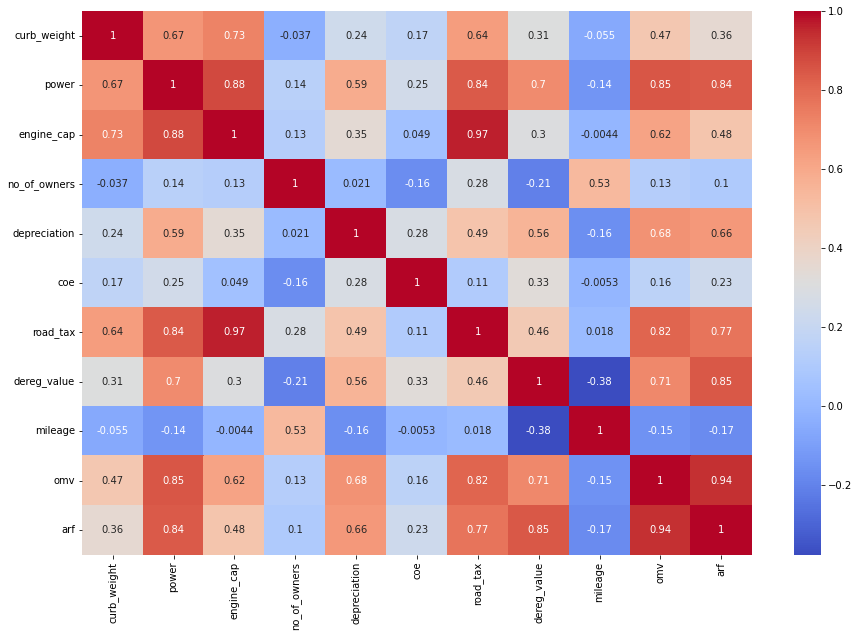

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(train[columns].corr(),annot=True, cmap="coolwarm");

In [ ]:
# these columns are dropped due to more nan values
drop_col = {'road_tax', 'arf'}
train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

#### Free text feature columns processing

In [ ]:
columns = ['features','accessories']
# v1 v2 v3 ... v32 d1 d2 d3 ... d32

In [93]:
drop_col = {'features','accessories'}
train = train.drop(drop_col, axis=1)
test = test.drop(drop_col, axis=1)

#### Categoric feature processing

In [94]:
columns=['make','model','type_of_vehicle','fuel_type', 'transmission']

In [95]:
# Target encoding
for c in columns:
  temp_dict = train.groupby([c])['price'].agg(['mean']).to_dict()['mean']
  train[c+'_target_mean'] = train[c].replace(temp_dict)
  test[c+'_target_mean']  = test[c].replace(temp_dict)

#### Frequency Encoding for Categorical Feature

In [96]:
self_encode_True= ['make','model','type_of_vehicle','fuel_type', 'transmission']

In [97]:
train, test = frequency_encoding(train, test, self_encode_True, self_encoding=True)

In [98]:
train.to_pickle('/content/drive/MyDrive/CS5228 Project/train_feature_v7.pkl') 
test.to_pickle('/content/drive/MyDrive/CS5228 Project/test_feature_v7.pkl')